In [0]:
!unzip test_Bh8pGW3.zip
!unzip train_DETg9GD.zip

In [0]:
import numpy as np
import pandas as pd
from random import randint
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
from matplotlib.pyplot import imread
from pylab import *
from albumentations import (RGBShift,Blur,RandomContrast,HueSaturationValue,RandomGamma,Rotate,RandomBrightness,HorizontalFlip, Normalize, Resize, Compose, GaussNoise,Transpose,RandomBrightnessContrast,RandomCrop)
from albumentations.pytorch import ToTensor
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import time
import copy

In [0]:
train_csv = pd.read_csv('/content/train.csv')
train_csv,val_csv = train_test_split(train_csv,test_size=0.06,random_state=8)
test_csv = pd.read_csv('/content/test.csv')
test_csv['Class']=""
test_csv.Class='MIDDLE'

In [115]:
print('train image count--',len(train_csv),'\t test image count--',len(test_csv),'\t val image count--',len(val_csv))
train_csv.Class.value_counts(normalize=True)

train image count-- 18711 	 test image count-- 6636 	 val image count-- 1195


MIDDLE    0.543103
YOUNG     0.336112
OLD       0.120785
Name: Class, dtype: float64

In [0]:
label_assign={'YOUNG':0,'MIDDLE':1,'OLD':2}

# knowing image shapes

In [0]:
l=[]
for i in range(len(train_csv)):
  img_path = '/content/Train/' + str(train_csv.ID[i])
  img = imread(img_path,format='jpg')
  l.append(img.shape)
l=np.array(l)

In [0]:
print(min(l[:,0]),min(l[:,1]))
print(max(l[:,0]),max(l[:,1]))
print(mean(l[:,0]),mean(l[:,1]))

11 8
713 724
125.46724605646538 99.01070029136943


# Building datasets and dataloaders before training

In [0]:
class dataset(Dataset):
  def __init__(self, csv_file, dir_path, phase):
    self.csv_file = csv_file
    self.dir_path = dir_path
    self.phase = phase
    self.transform = get_transforms(self.phase)

  def __len__(self):
    return len(self.csv_file)

  def __getitem__(self,idx):
    img_path = os.path.join(self.dir_path, self.csv_file.iloc[idx, 0])
    image = imread(img_path)
    label = label_assign[self.csv_file.iloc[idx, 1]]
    aug_img = self.transform(image=image)
    image = aug_img["image"]
    return image,label

def get_transforms(phase):
  t_list=[]
  if phase=='train':
    t_list.extend([RandomBrightness(limit=0.8, p=0.5),
                   Rotate(limit=25, p=0.5),
                   RGBShift(r_shift_limit=50, g_shift_limit=30, b_shift_limit=40, p=0.5),
                   RandomGamma(gamma_limit=(80,165), p=0.5),
                   HorizontalFlip(p=0.5),
                   HueSaturationValue(hue_shift_limit=10, sat_shift_limit=30, val_shift_limit=30, p=0.5),
                   RandomContrast(limit=0.5, p=0.5),
                   RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5)
                   ])
  t_list.extend([Resize(128, 100, interpolation=1, p=1),    ## 16x16, 64x64 , 128x100
                 Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
                 ToTensor()])
  return  Compose(t_list)

In [118]:
### creating train and test datasets
train_dataset = dataset(train_csv,'/content/Train/','train')
test_dataset = dataset(test_csv,'/content/Test/','test')
val_dataset = dataset(val_csv,'/content/Train/','val')
dataset_sizes={'train':len(train_dataset),'val':len(val_dataset),'test':len(test_dataset)}
print(dataset_sizes)

{'train': 18711, 'val': 1195, 'test': 6636}


In [119]:
### visualising datasets
a=randint(0,1700)
print("VISUALISING TRAIN DATASET")
for i in range(a,a+10):
  image, label = train_dataset[i]
  print(i,'\t', image.shape,'\t', label)
print("\nVISUALISING TEST DATASET")
b=randint(0,6625)
for i in range(b,b+10):
  image, label = test_dataset[i]
  print(i,'\t', image.shape,'\t', label)

VISUALISING TRAIN DATASET
68 	 torch.Size([3, 128, 100]) 	 0
69 	 torch.Size([3, 128, 100]) 	 2
70 	 torch.Size([3, 128, 100]) 	 2
71 	 torch.Size([3, 128, 100]) 	 1
72 	 torch.Size([3, 128, 100]) 	 1
73 	 torch.Size([3, 128, 100]) 	 0
74 	 torch.Size([3, 128, 100]) 	 0
75 	 torch.Size([3, 128, 100]) 	 1
76 	 torch.Size([3, 128, 100]) 	 1
77 	 torch.Size([3, 128, 100]) 	 1

VISUALISING TEST DATASET
5692 	 torch.Size([3, 128, 100]) 	 1
5693 	 torch.Size([3, 128, 100]) 	 1
5694 	 torch.Size([3, 128, 100]) 	 1
5695 	 torch.Size([3, 128, 100]) 	 1
5696 	 torch.Size([3, 128, 100]) 	 1
5697 	 torch.Size([3, 128, 100]) 	 1
5698 	 torch.Size([3, 128, 100]) 	 1
5699 	 torch.Size([3, 128, 100]) 	 1
5700 	 torch.Size([3, 128, 100]) 	 1
5701 	 torch.Size([3, 128, 100]) 	 1


In [0]:
dataloader={}
dataloader['train'] = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=1)
dataloader['test'] = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=1)
dataloader['val'] = DataLoader(val_dataset, batch_size=256, shuffle=True, num_workers=1)

0 torch.Size([256, 3, 128, 100]) torch.Size([256])
1 torch.Size([256, 3, 128, 100]) torch.Size([256])
2 torch.Size([256, 3, 128, 100]) torch.Size([256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 torch.Size([256, 3, 128, 100]) torch.Size([256])
batch size-- 256
img size-- 128


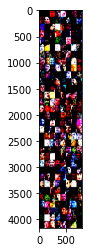

In [121]:
### visualing batches
def show_batch(sample_batch):
  img_batch,label_batch = sample_batch
  print('batch size--',len(img_batch))
  print('img size--',img_batch.size(2))
  grid_border_size = 2
  grid = torchvision.utils.make_grid(img_batch)
  plt.imshow(grid.numpy().transpose((1, 2, 0)))

for i, sample_batch in enumerate(dataloader['train']):
  img, label = sample_batch
  print(i, img.size(), label.shape)
  if i==3:
    show_batch(sample_batch)
    break

# Trainer

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    latest_model_wts = copy.deepcopy(model.state_dict())
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for img_batch, labels in dataloader[phase]:
                img_batch = img_batch.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(img_batch)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * img_batch.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            latest_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Training model with freeze

In [123]:
# lr_list = np.random.rand(20)
# lr_list = 10**(-5*lr_list)
# for lr in lr_list:
#   print('***********\tLR =',lr,'\t************')
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)

device = torch.device("cuda")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.004, momentum=0.9, nesterov=True)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


best_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=13)

Epoch 0/12
----------
train Loss: 0.9030 Acc: 0.5903
val Loss: 0.8016 Acc: 0.6460

Epoch 1/12
----------
train Loss: 0.8345 Acc: 0.6296
val Loss: 0.7904 Acc: 0.6502

Epoch 2/12
----------
train Loss: 0.8133 Acc: 0.6380
val Loss: 0.8146 Acc: 0.6427

Epoch 3/12
----------
train Loss: 0.8080 Acc: 0.6434
val Loss: 0.8243 Acc: 0.6318

Epoch 4/12
----------
train Loss: 0.8077 Acc: 0.6408
val Loss: 0.7857 Acc: 0.6460

Epoch 5/12
----------
train Loss: 0.8019 Acc: 0.6440
val Loss: 0.8528 Acc: 0.6084

Epoch 6/12
----------
train Loss: 0.8113 Acc: 0.6368
val Loss: 0.7821 Acc: 0.6527

Epoch 7/12
----------
train Loss: 0.8014 Acc: 0.6415
val Loss: 0.7647 Acc: 0.6728

Epoch 8/12
----------
train Loss: 0.7961 Acc: 0.6483
val Loss: 0.7664 Acc: 0.6669

Epoch 9/12
----------
train Loss: 0.7959 Acc: 0.6470
val Loss: 0.7607 Acc: 0.6736

Epoch 10/12
----------
train Loss: 0.7892 Acc: 0.6510
val Loss: 0.7620 Acc: 0.6711

Epoch 11/12
----------
train Loss: 0.7896 Acc: 0.6520
val Loss: 0.7622 Acc: 0.6762

Ep

# Unfreeze and training (fine tuning)

In [0]:
model = best_model
for param in model.parameters():
    param.requires_grad = True

device = torch.device("cuda")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [125]:
new_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.7538 Acc: 0.6830
val Loss: 0.8249 Acc: 0.6285

Epoch 1/49
----------
train Loss: 0.5942 Acc: 0.7470
val Loss: 0.5928 Acc: 0.7523

Epoch 2/49
----------
train Loss: 0.5106 Acc: 0.7862
val Loss: 0.4721 Acc: 0.8084

Epoch 3/49
----------
train Loss: 0.4349 Acc: 0.8224
val Loss: 0.4991 Acc: 0.8033

Epoch 4/49
----------
train Loss: 0.3797 Acc: 0.8466
val Loss: 0.4221 Acc: 0.8310

Epoch 5/49
----------
train Loss: 0.3372 Acc: 0.8637
val Loss: 0.4039 Acc: 0.8502

Epoch 6/49
----------
train Loss: 0.3101 Acc: 0.8750
val Loss: 0.3775 Acc: 0.8561

Epoch 7/49
----------
train Loss: 0.2814 Acc: 0.8876
val Loss: 0.3426 Acc: 0.8695

Epoch 8/49
----------
train Loss: 0.2441 Acc: 0.9037
val Loss: 0.4279 Acc: 0.8435

Epoch 9/49
----------
train Loss: 0.2336 Acc: 0.9099
val Loss: 0.3970 Acc: 0.8569

Epoch 10/49
----------
train Loss: 0.2141 Acc: 0.9182
val Loss: 0.3933 Acc: 0.8636

Epoch 11/49
----------
train Loss: 0.1944 Acc: 0.9241
val Loss: 0.3675 Acc: 0.8753

Ep

# Prediction on test 

In [0]:
label_decoding={0:'YOUNG',1:'MIDDLE',2:'OLD'}

In [127]:
prediction = torch.tensor([],dtype=torch.int64)
prediction = prediction.to(device)
for inputs, labels in dataloader['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = new_model(inputs)
            _, preds = torch.max(outputs, 1)
            #print(type(preds),preds.shape,preds.dtype,preds.device)
            prediction = torch.cat((prediction,preds),0)
            #print(prediction.shape,prediction.device)
print(prediction.shape)

torch.Size([6636])


In [128]:
sub_csv = test_csv.copy()
prediction = prediction.to('cpu')
print(prediction.device)
for i in range(len(prediction)):
  sub_csv.Class[i] = label_decoding[int(prediction[i])]

cpu


In [129]:
test_csv.head()

,ID,Class
0,25321.jpg,MIDDLE
1,989.jpg,MIDDLE
2,19277.jpg,MIDDLE
3,13093.jpg,MIDDLE
4,5367.jpg,MIDDLE


In [130]:
sub_csv.head()

,ID,Class
0,25321.jpg,MIDDLE
1,989.jpg,YOUNG
2,19277.jpg,MIDDLE
3,13093.jpg,MIDDLE
4,5367.jpg,MIDDLE


In [0]:
sub_csv.to_csv('/content/sample_submission_sDO3m7O.csv',index=False)